In [2]:
%pylab inline
from astropy.table import Table
from rnn import RNNClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import copy

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# Loading dataset
#data_table = Table.read('normalized_sub_mean.fits')
data_table = Table.read('normalized_good.fits')

In [4]:
# Splitting training and testing data
np.random.seed(1234)
randomize_inds = range(len(data_table))
randomize_inds = permutation(randomize_inds)
randomized_inds_train = randomize_inds[0:15000]
randomized_inds_test  = randomize_inds[15000:]

In [5]:
data_table['label'] = 1.0*(data_table['SNTYPE'].astype('int') == 1)

In [6]:
# Define input function for training 
def input_fn_train():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.repeat().shuffle(10000).batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_train_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_train[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32')
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_train))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

def input_fn_test():
    def mapping_function(x):
        def extract_batch(inds):
            inds = randomized_inds_test[inds]
            return data_table['label'][inds].astype('float32'), clip(data_table['num_data_points'][inds],0,49).astype('int32'),data_table['DATA'][inds].astype('float32') 
        a,b,c =tf.py_func( extract_batch, [x], [tf.float32, tf.int32, tf.float32])
        a.set_shape([None])
        b.set_shape([None])
        c.set_shape([None,50,9])
        return a,b,c

    dataset = tf.data.Dataset.range(len(randomized_inds_test))
    dataset = dataset.batch(512)
    dataset = dataset.map( mapping_function)
    iterator = dataset.make_one_shot_iterator()
    label, length, ts = iterator.get_next()
    return  {'length':length, 'ts':ts}, label

In [7]:
#model = RNNClassifier(hidden_units=[128, 128], dropout=1, model_dir='tests/test_1')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_2')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_5')
#model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_6')
model = RNNClassifier(hidden_units=[128, 128], dropout=0.8, model_dir='tests/test_10')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tests/test_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11a846710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
#model.train(input_fn=input_fn_train, steps=10000)

In [9]:
# Apply model to test set
test_prob = [p['prob'] for p in model.predict(input_fn_test)]
table_test = data_table[randomized_inds_test]
table_test['p'] = test_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_10/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [10]:
# Apply model to training set
train_prob = [p['prob'] for p in model.predict(input_fn_train_test)]
table_train = data_table[randomized_inds_train]
table_train['p'] = train_prob

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tests/test_10/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


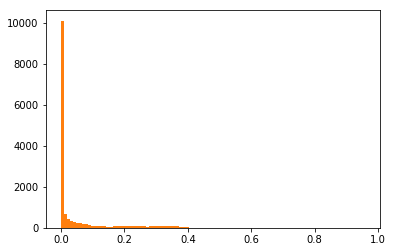

In [11]:
hist(test_prob, 100);
hist(train_prob,100);

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 1)

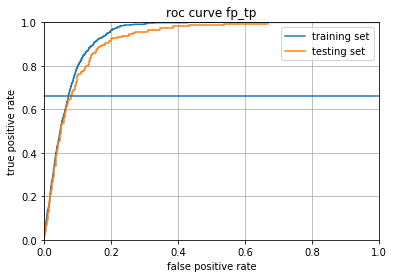

In [12]:
# Compute ROC curves 
from sklearn.metrics import roc_curve

fpr1, tpr1, thr1 = roc_curve(table_train['label'], table_train['p'])
fpr2, tpr2, thr2 = roc_curve(table_test['label'], table_test['p'])

plot(fpr1, tpr1,label='training set')
plot(fpr2, tpr2,label='testing set')
title("roc curve fp_tp")
xlabel('false positive rate')
ylabel('true positive rate')
grid('on')
#xscale('log')
legend()
axhline(0.661)
xlim(0,1)
ylim(0,1)

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
roc_auc_score(table_train['label'], table_train['p'])

0.9349993778317651

In [15]:
roc_auc_score(table_test['label'], table_test['p'])

0.9176599432413387

In [21]:
# Compute Confusion Matrix
from sklearn.metrics import confusion_matrix

threshold=0.083

actual = table_test['label']
predict = table_test['p'] > threshold

confusion_matrix(actual, predict)

array([[2738,  444],
       [  27,  138]])

In [22]:
FP = (table_test['p'] > threshold) * (table_test['label'] == 0)
TP = (table_test['p'] > threshold) * (table_test['label'] == 1)
FN = (table_test['p'] < threshold) * (table_test['label'] == 1)
TN = (table_test['p'] < threshold) * (table_test['label'] == 0)

P = (table_test['label'] == 1)
N = (table_test['label'] == 0)

FP_table = table_test[FP]
FN_table = table_test[FN]
TP_table = table_test[TP]
TN_table = table_test[TN]
P_table = table_test[P]
N_table = table_test[N]

print("fp: " + str(len(FP_table)))
print("fn: " + str(len(FN_table)))
print("tp: " + str(len(TP_table)))
print("tn: " + str(len(TN_table)))
print("p: " + str(len(P_table)))
print("n: " + str(len(N_table)))

fp: 444
fn: 27
tp: 138
tn: 2738
p: 165
n: 3182


In [29]:
# Compute Confusion Matrix for specific types

FP_orig_types = (FP_table['SNTYPE'].astype('int')).flatten()
TN_orig_types = (TN_table['SNTYPE'].astype('int')).flatten()

FP_distr = []
for a in np.unique(FP_orig_types):
    FP_distr += [(str(a),len(FP_table[FP_orig_types == a]))]
    
TN_distr = []
for a in np.unique(TN_orig_types):
    TN_distr += [(str(a),len(TN_table[TN_orig_types == a]))]

In [30]:
(FP_distr, TN_distr)

([('-9', 420), ('3', 3), ('22', 1), ('23', 2), ('32', 9), ('33', 9)],
 [('-9', 2676), ('21', 10), ('22', 38), ('32', 9), ('33', 5)])

In [31]:
FP_nine = FP_table[FP_orig_types == -9]
FP_Ibc = FP_table[FP_orig_types == 3]
FP_IIn = FP_table[FP_orig_types == 21]
FP_IIP = FP_table[FP_orig_types == 22]
FP_IIL = FP_table[FP_orig_types == 23]
FP_Ib = FP_table[FP_orig_types == 32]
FP_Ic = FP_table[FP_orig_types == 33]

In [32]:
TN_nine = TN_table[TN_orig_types == -9]
TN_Ibc = TN_table[TN_orig_types == 3]
TN_IIn = TN_table[TN_orig_types == 21]
TN_IIP = TN_table[TN_orig_types == 22]
TN_IIL = TN_table[TN_orig_types == 23]
TN_Ib = TN_table[TN_orig_types == 32]
TN_Ic = TN_table[TN_orig_types == 33]

In [33]:
C_M = np.array([[len(TP_table), len(FP_nine), len(FP_IIn), len(FP_IIP), 
                 len(FP_IIL), len(FP_Ibc), len(FP_Ib), len(FP_Ic)],
                [len(FN_table), len(TN_nine), len(TN_IIn), len(TN_IIP),
                 len(TN_IIL), len(TN_Ibc), len(TN_Ib), len(TN_Ic)]])

In [34]:
C_M

array([[ 138,  420,    0,    1,    2,    3,    9,    9],
       [  27, 2676,   10,   38,    0,    0,    9,    5]])

In [35]:
# Normalize Confusion Matrix

C_M = C_M.astype('float64')
CM_copy = copy.deepcopy(C_M)
SUM = CM_copy.sum(axis=0)
SUM = SUM.astype('float64')
for i in range(len(SUM)):
    if SUM[i]>0:
        print(SUM[i])
        C_M[0,i] /= SUM[i]
        C_M[1,i] /= SUM[i]

165.0
3096.0
10.0
39.0
2.0
3.0
18.0
14.0


Normalized confusion matrix
[[0.83636364 0.13565891 0.         0.02564103 1.         1.
  0.5        0.64285714]
 [0.16363636 0.86434109 1.         0.97435897 0.         0.
  0.5        0.35714286]]


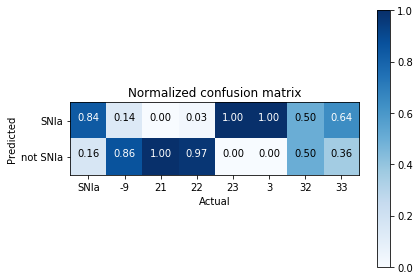

In [36]:
# Plot Confusion Matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt

print("Normalized confusion matrix")
print(C_M)

np.set_printoptions(precision=2)
plt.figure()

plt.imshow(C_M, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized confusion matrix")
plt.colorbar()

x_classes = np.array(['SNIa',"-9","21","22","23","3","32","33"])
y_classes = np.array(["SNIa", "not SNIa"])
x_marks = np.arange(len(x_classes))
y_marks = np.arange(len(y_classes))
plt.xticks(x_marks, x_classes)
plt.yticks(y_marks, y_classes)

fmt = '.2f'
thresh = C_M.max() / 2.
for i, j in itertools.product(range(C_M.shape[0]), range(C_M.shape[1])):
    plt.text(j, i, format(C_M[i, j], fmt), horizontalalignment="center",
                 color="white" if C_M[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Predicted')
plt.xlabel('Actual')

plt.show()


In [37]:
# Compute other metrics

Accuracy = (len(TP_table) + len(TN_table))/(len(table_test))
Purity = len(TP_table)/(len(TP_table) + len(FP_table))
Completeness = len(TP_table)/(len(TP_table) + len(FN_table))
FOM = Completeness * (len(TP_table)/(len(TP_table) + 3*len(FP_table)))

In [38]:
(Accuracy, Purity, Completeness, FOM)

(0.8592769644457723,
 0.23711340206185566,
 0.8363636363636363,
 0.07851576994434137)

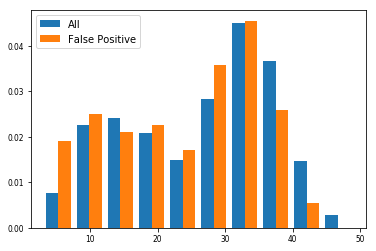

In [148]:
datapointshist = [table_test['num_data_points'],FP_table['num_data_points']]
hist(datapointshist, 10, density = True, histtype='bar', label = ["All","False Positive"])
legend(prop={'size': 10})

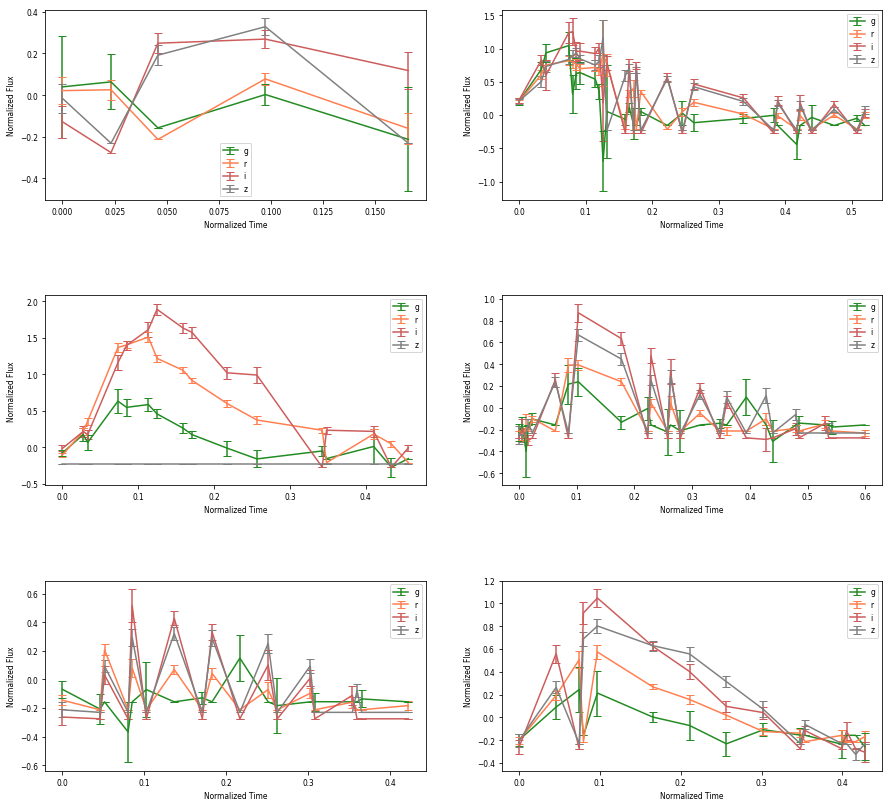

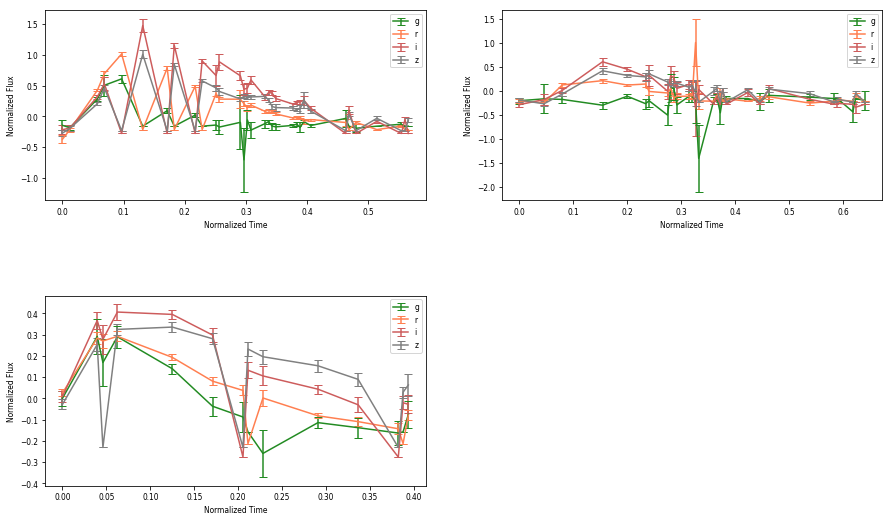

In [41]:
# Make plots for missclassified types

output = FP_Ic # Define which missclassified type to plot

plot_ind = 0
plot_tot = len(output) #for type -9 use a smaller number because there are too many

while plot_ind < plot_tot: 
    plot_num = 321
    fig = plt.figure(figsize=(15, 14))
    for x in range(6):
        plt.rcParams.update({'font.size': 7.5})
        plt.subplot(plot_num)
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)
        
        num_points = output[plot_ind]['num_data_points']-1
        #-1 is temporary and will be removed once the missing point problem is resolved
        MJD = output['DATA'][plot_ind,:num_points,0]
        g_FLUXCAL = output['DATA'][plot_ind,:num_points,1]
        r_FLUXCAL = output['DATA'][plot_ind,:num_points,2]
        i_FLUXCAL = output['DATA'][plot_ind,:num_points,3]
        z_FLUXCAL = output['DATA'][plot_ind,:num_points,4]

        g_err = output['DATA'][plot_ind,:num_points,5]
        r_err = output['DATA'][plot_ind,:num_points,6]
        i_err = output['DATA'][plot_ind,:num_points,7]
        z_err = output['DATA'][plot_ind,:num_points,8]

        plt.errorbar(MJD, g_FLUXCAL, g_err, capsize = 4, label='g',color = 'forestgreen') 
        plt.errorbar(MJD, r_FLUXCAL, r_err, capsize = 4, label='r',color = 'coral')
        plt.errorbar(MJD, i_FLUXCAL, i_err, capsize = 4, label='i', color = 'indianred')
        plt.errorbar(MJD, z_FLUXCAL, z_err, capsize = 4, label='z', color = 'gray')

        plt.xlabel('Normalized Time')
        plt.ylabel('Normalized Flux')
        plt.legend()
        
        plot_num += 1
        plot_ind += 1
        if plot_ind >= plot_tot: break
plt.show()

In [103]:
#Calculate S/N
        
from astropy.io import ascii

def get_individual_SNR(filename):
    rdr = ascii.get_reader(Reader=ascii.Basic)
    rdr.header.splitter.delimiter = ' '
    rdr.data.splitter.delimiter = ' '
    rdr.header.start_line = 12
    rdr.data.start_line = 13
    rdr.data.end_line = None
    t = rdr.read('DES_BLINDnoHOSTZ/' + filename)
    
    FLUXCALERR = t['FLUXCALERR']
    MJD = t['MJD']
    UMJD = MJD[FLUXCALERR>0]
    FLT = t['FLT']
    UFLT = FLT[FLUXCALERR>0]
    FLUXCAL = t['FLUXCAL']
    UFLUXCAL = FLUXCAL[FLUXCALERR>0]
    UFLUXCALERR = FLUXCALERR[FLUXCALERR>0]
    
    Signal = sum(square(UFLUXCAL))
    Noise = sum(square(UFLUXCALERR))
    return sqrt(Signal/Noise)

def get_SNR(group):
    name_list = group['FILENAME']
    total = len(name_list)
    index = 0
    SNR_list = []
    for index in range(total):
        SNR_list += [get_individual_SNR(name_list[index])]
    return np.array(SNR_list)

In [104]:
dataset_SNR = get_SNR(data_table)

In [118]:
len(dataset_SNR[dataset_SNR>4])/len(dataset_SNR)

0.31650951109173164

In [119]:
get_individual_SNR("DES_SN002544.DAT")

2.855384684106586

(array([14990.,  1975.,   587.,   302.,   185.,    84.,    84.,    57.,
           40.,    43.]),
 array([ 0.73,  6.01, 11.29, 16.58, 21.86, 27.14, 32.42, 37.71, 42.99,
        48.27, 53.55]),
 <a list of 10 Patch objects>)

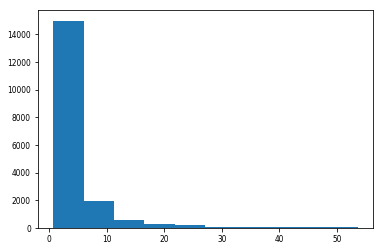

In [106]:
hist(dataset_SNR)

In [108]:
FP_SNR = get_SNR(FP_table)
FN_SNR = get_SNR(FN_table)
TP_SNR = get_SNR(TP_table)
TN_SNR = get_SNR(TN_table)

In [65]:
# Get S/N for FP from specific types
FP_nine_SNR = get_SNR(FP_nine) # -9
FP_Ibc_SNR = get_SNR(FP_Ibc) #3
FP_IIn_SNR = get_SNR(FP_IIn) #21
FP_IIP_SNR = get_SNR(FP_IIP) #22
FP_IIL_SNR = get_SNR(FP_IIL) #23
FP_Ib_SNR = get_SNR(FP_Ib) #32
FP_Ic_SNR = get_SNR(FP_Ic) #33

In [66]:
# Get S/N for FN from specific types
FN_nine_SNR = get_SNR(FP_nine) # -9
FN_Ibc_SNR = get_SNR(FP_Ibc) #3
FN_IIn_SNR = get_SNR(FP_IIn) #21
FN_IIP_SNR = get_SNR(FP_IIP) #22
FN_IIL_SNR = get_SNR(FP_IIL) #23
FN_Ib_SNR = get_SNR(FP_Ib) #32
FN_Ic_SNR = get_SNR(FP_Ic) #33

In [67]:
mis_SNR = FP_SNR + FN_SNR
corr_SNR = TP_SNR + TN_SNR

mis_nine_SNR = FP_nine_SNR + FN_nine_SNR
mis_Ibc_SNR = FP_Ibc_SNR + FN_Ibc_SNR
mis_IIn_SNR = FP_IIn_SNR + FN_IIn_SNR
mis_IIP_SNR = FP_IIP_SNR + FN_IIP_SNR
mis_IIL_SNR = FP_IIL_SNR + FN_IIL_SNR
mis_Ib_SNR = FP_Ib_SNR + FN_Ib_SNR
mis_Ic_SNR = FP_Ic_SNR + FN_Ic_SNR

Text(0.5,1,'S/N for TP+TN vs FP+FN')

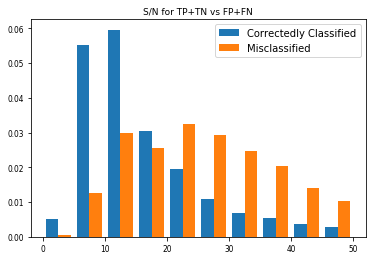

In [143]:
hist([corr_SNR,mis_SNR], 10, (0,50), density = True, histtype='bar', label = ["Correctedly Classified","Misclassified"])
legend(prop={'size': 10})
title("S/N for TP+TN vs FP+FN")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Text(0.5,1,'S/N of FP in specific types')

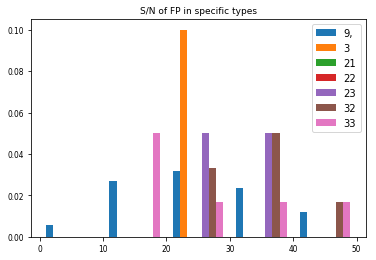

In [146]:
hist([mis_nine_SNR, mis_Ibc_SNR,mis_IIn_SNR,mis_IIP_SNR,mis_IIL_SNR,mis_Ib_SNR,mis_Ic_SNR], 5, (0,50), True, histtype='bar', 
     label = ["9,","3","21","22","23","32","33"])
legend(prop={'size': 10})
title("S/N of FP in specific types")